<a href="https://colab.research.google.com/github/Rintaro-Fukui/CIFAR10-API/blob/resnet/model-train/notebooks/resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# training
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), #ランダムに水平に反転
    transforms.ColorJitter(), #ランダムに色を変更
    transforms.RandomRotation(10), #ランダムに回転
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
trainset = torchvision.datasets.CIFAR10(root='./', train=True, download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

# test
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
testset = torchvision.datasets.CIFAR10(root='./', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True, num_workers=2)

100%|██████████| 170498071/170498071 [00:02<00:00, 62011018.68it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [4]:
print('train: ', trainset.data.shape)
print('test: ', testset.data.shape)

classes = trainset.classes
print(classes)

train:  (50000, 32, 32, 3)
test:  (10000, 32, 32, 3)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


<class 'torch.Tensor'>
<class 'numpy.ndarray'>
(3, 274, 274)
(274, 274, 3)


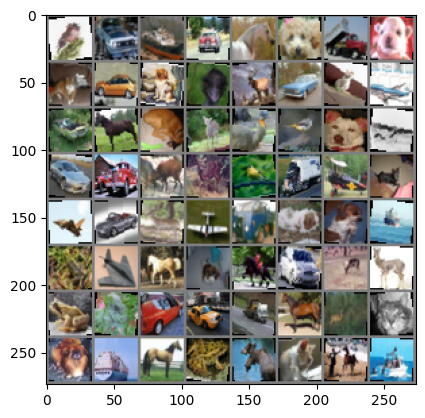

In [5]:
def imshow(img):
    img = img / 2 + 0.5
    print(type(img))
    npimg = img.numpy()
    print(type(npimg))
    print(npimg.shape)
    npimg = np.transpose(npimg, (1, 2, 0))
    print(npimg.shape)
    plt.imshow(npimg)
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

In [6]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)
net = model.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 95.4MB/s]


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

In [ ]:
num_epochs = 10
losses = []
accs = []
val_losses = []
val_accs = []

best_model_wts = copy.deepcopy(net.state_dict())
best_acc = 0.0

In [15]:
for epoch in range(num_epochs):

    # train
    running_loss = 0.0
    running_acc = 0.0

    for imgs, labels in trainloader:

        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        output = net(imgs)

        loss = criterion(output, labels)
        loss.backward()
        running_loss += loss.item()

        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())

        optimizer.step()

    running_loss /= len(trainloader)
    running_acc /= len(trainloader)
    losses.append(running_loss)
    accs.append(running_acc)

    # test
    val_running_loss = 0.0
    val_running_acc = 0.0

    for val_imgs, val_labels in testloader:

        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)

        val_output = net(val_imgs)

        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()

        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())

    val_running_loss /= len(testloader)
    val_running_acc /= len(testloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)

    if val_running_acc > best_acc:
        best_acc = val_running_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print(f"epoch: {epoch}, loss: {running_loss}, acc: {running_acc}, \
        val_loss: {val_running_loss}, val_acc: {val_running_acc}")

net.load_state_dict(best_model_wts)

epoch: 0, loss: 0.5521190282328964, acc: 0.8117207288742065,         val_loss: 0.5971305121661751, val_acc: 0.796675980091095
epoch: 1, loss: 0.5372577704622618, acc: 0.8166759610176086,         val_loss: 0.58189463539488, val_acc: 0.8041401505470276
epoch: 2, loss: 0.5251728313429581, acc: 0.8214313983917236,         val_loss: 0.5780376733108691, val_acc: 0.8020501732826233
epoch: 3, loss: 0.5274339803420675, acc: 0.8207520842552185,         val_loss: 0.6132597676507986, val_acc: 0.7924960255622864
epoch: 4, loss: 0.5160030654972166, acc: 0.8233495950698853,         val_loss: 0.5679144487259494, val_acc: 0.8078224658966064
epoch: 5, loss: 0.5084918395561331, acc: 0.824588418006897,         val_loss: 0.5700829655501494, val_acc: 0.8045382499694824
epoch: 6, loss: 0.5040128150445116, acc: 0.8297034502029419,         val_loss: 0.577136691019034, val_acc: 0.8040406107902527
epoch: 7, loss: 0.5080130101203004, acc: 0.8259870409965515,         val_loss: 0.5765950470972973, val_acc: 0.806926

<All keys matched successfully>

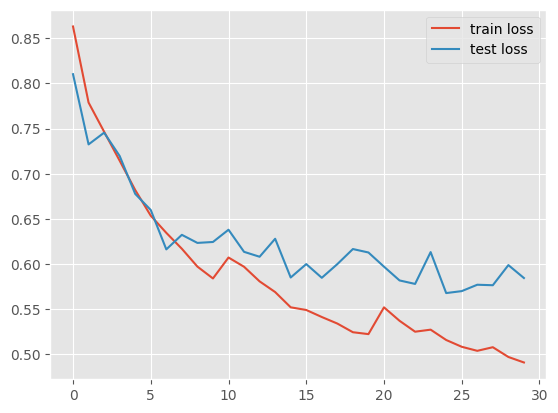

In [16]:
plt.style.use("ggplot")
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="test loss")
plt.legend()

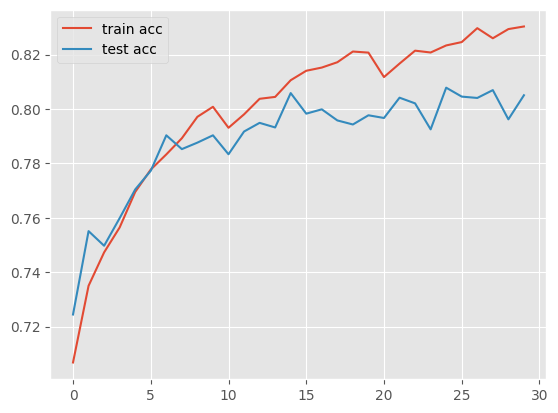

In [17]:
accs_array = [t.detach().cpu().numpy() for t in accs]
val_accs_array = [t.detach().cpu().numpy() for t in val_accs]
plt.plot(accs_array, label="train acc")
plt.plot(val_accs_array, label="test acc")
plt.legend()